In [14]:
import json
import re
import pickle
import mowl
mowl.init_jvm("4g")
import networkx as nx
import matplotlib.pyplot as plt

First we have to read the ontology graph

In [2]:
Onto_graph_raw = []
with (open("../../Data/Input/Graph_mesh_OWL2VEC.pkl", "rb")) as openfile:
    while True:
        try:
            Onto_graph_raw.append(pickle.load(openfile))
        except EOFError:
            break

Here we are formatting the information of the projected graph in a more efficient data structure.

In [66]:

id2idx = {}
idx_ref = -1

# A weird term is a term that not complies with the MeSH format of ids, MeSH_id examples = "D007484", "T083", "Q000266"
def findWeirTerm(term, dict):
    if(len(re.findall("[A-Z]+[0-9]+", term)) == 0):
        if(term in dict): dict[term] += 1
        else: dict[term] = 1
    return dict

def getIdx(id):
    if(id in id2idx):
        return id2idx[id]
    else:
        global idx_ref
        idx_ref+=1
        id2idx[id] = idx_ref
        id2idx[idx_ref] = id
        
        return idx_ref

def format_Big(raw_graph):
    v = 0
    new_G = nx.DiGraph()
    weird_terms = {}
    for section in raw_graph:
        for edge in section:
            # print(edge.src)
            src = edge.src.split("/")[-1]
            rel = edge.rel.split("/")[-1]
            dst = edge.dst.split("/")[-1]
            
            weird_terms = findWeirTerm(src,weird_terms)
            weird_terms = findWeirTerm(dst,weird_terms)
            
            if(rel == "superclassof"):
                new_G.add_edge(getIdx(src),getIdx(dst))
    
    print(weird_terms)
    return new_G

big_G = format_Big(Onto_graph_raw)

{'owl#Thing': 236, 'core#OrderedCollection': 3, 'core#Collection': 2, '22-rdf-syntax-ns#List': 1, 'core#Concept': 12, 'core#ConceptScheme': 4}


## Visualize part of the graph

I think the root of the tree is owl#Thing, we want to create the bfs tree from the root and assign a lvl to the nodes that we find on the way.

393
696


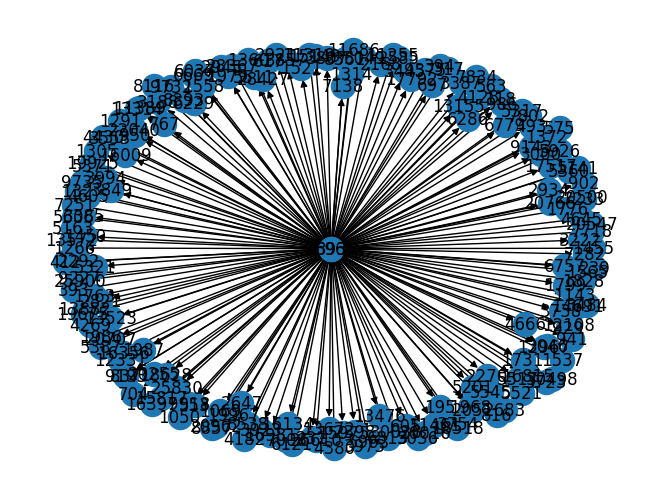

In [72]:
def dfs_tree_from(source_node):
    tree = nx.bfs_tree(big_G, source=id2idx[source_node], depth_limit=1)
    print(id2idx[source_node])
    nx.draw_spring(tree,with_labels = True)
    plt.clf()

dfs_tree_from("D013514")
dfs_tree_from("owl#Thing")

We want to check wich node has no predecesors, thus becoming the root

In [70]:
print(nx.is_tree(big_G))
print(nx.is_forest(big_G))
print(nx.is_branching(big_G))

False
False
False


In [47]:
i = 0
for node in list(big_G.nodes):
    ancestor = nx.dfs_predecessors(big_G, source=node, depth_limit=1)
    if(len(ancestor.keys()) == 1):
        print(node)
        print(ancestor)
    i+=1
    if(i==50):break
    

2
{3: 2}
12
{13: 12}
14
{15: 14}
18
{19: 18}
24
{25: 24}
30
{31: 30}
36
{37: 36}
38
{39: 38}
46
{47: 46}


Once we find the root of the tree, we can use 
```
    nx.descendants_at_distance(G, source, distance)
```
or
```
    bfs_layers(G, sources)
```
To determine the depth of the nodes and create our input file, for the next layer